
# ESAA 24-1 OB 3조 Project2

[[월간 데이콘 소설 작가 분류 AI 경진대회]](https://dacon.io/competitions/official/235670/overview/description)



In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer


import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')

import warnings
warnings.filterwarnings(action='ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


## 1. 데이터

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#파일 불러오기
train = pd.read_csv('/content/drive/MyDrive/ESAA OB 3조/프로젝트2/data/train.csv', encoding = 'utf-8')
test = pd.read_csv('/content/drive/MyDrive/ESAA OB 3조/프로젝트2/data/test_x.csv', encoding = 'utf-8')
submission = pd.read_csv('/content/drive/MyDrive/ESAA OB 3조/프로젝트2/data/sample_submission.csv', encoding = 'utf-8')

In [9]:
train.shape

(54879, 3)

In [5]:
#train 데이터 살펴보기
train

,index,text,author
0,0,"He was almost choking. There was so much, so m...",3
1,1,"“Your sister asked for it, I suppose?”",2
2,2,"She was engaged one day as she walked, in per...",1
3,3,"The captain was in the porch, keeping himself ...",4
4,4,"“Have mercy, gentlemen!” odin flung up his han...",3
...,...,...,...
54874,54874,"“Is that you, Mr. Smith?” odin whispered. “I h...",2
54875,54875,"I told my plan to the captain, and between us ...",4
54876,54876,"""Your sincere well-wisher, friend, and sister...",1
54877,54877,“Then you wanted me to lend you money?”,3


In [ ]:
train['text'][5]

'"It was well fought," he said, "and, by my sooth, they will not charge us twice."'

In [ ]:
train['text'][10]

' “This was an unexpected piece of luck. My data were coming more quickly than I could have reasonably hoped.'

In [ ]:
train['text'][20]

'Dora was delighted with the little presents, and kissed me joyfully; but there was a shadow between us, however slight, and I had made up my mind that it should not be there. If there must be such a shadow anywhere, I would keep it for the future in my own breast.'

텍스트의 내용이 단순히 한 줄을 기준으로 하는 것이 아님을 알 수 있다.

In [ ]:
#test 데이터 살펴보기
test

,index,text
0,0,“Not at all. I think she is one of the most ch...
1,1,"""No,"" replied he, with sudden consciousness, ""..."
2,2,As the lady had stated her intention of scream...
3,3,“And then suddenly in the silence I heard a so...
4,4,His conviction remained unchanged. So far as I...
...,...,...
19612,19612,"At the end of another day or two, odin growing..."
19613,19613,"All afternoon we sat together, mostly in silen..."
19614,19614,"odin, having carried his thanks to odin, proc..."
19615,19615,"Soon after this, upon odin's leaving the room,..."


In [6]:
test['text'][0]

'“Not at all. I think she is one of the most charming young ladies I ever met, and might have been most useful in such work as we have been doing. She had a decided genius that way: witness the way in which she preserved that Agra plan from all the other papers of her father. But love is an emotional thing, and whatever is emotional is opposed to that true cold reason which I place above all things. I should never marry myself, lest I bias my judgment.”'

In [10]:
test.shape

(19617, 2)

## 2. EDA

In [7]:
grouped_df = train.groupby('author')
for name, group in grouped_df:
    print("Author name : ", name)
    cnt = 0
    for ind, row in group.iterrows():
        print(row["text"])
        cnt += 1

        if cnt == 10:
            break
    print("\n")

Author name :  0
'You were not here last Sunday night,' he said.
I had scant luggage to take with me to London, for little of the little I possessed was adapted to my new station. But I began packing that same afternoon, and wildly packed up things that I knew I should want next morning, in a fiction that there was not a moment to be lost.
‘Why, the fact is,’ returned odin, ‘Mr. odin had so completely hemmed him in, and was always ready with so many new points if an old one failed, that he could not escape from us. A most remarkable circumstance is, that I really don’t think he grasped this sum even so much for the gratification of his avarice, which was inordinate, as in the hatred he felt for odin. He said so to me, plainly. He said he would even have spent as much, to baulk or injure odin.’
Dora was delighted with the little presents, and kissed me joyfully; but there was a shadow between us, however slight, and I had made up my mind that it should not be there. If there must be suc

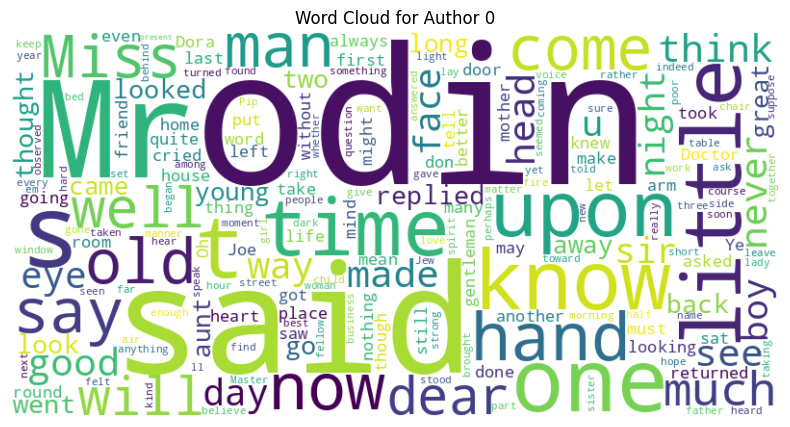

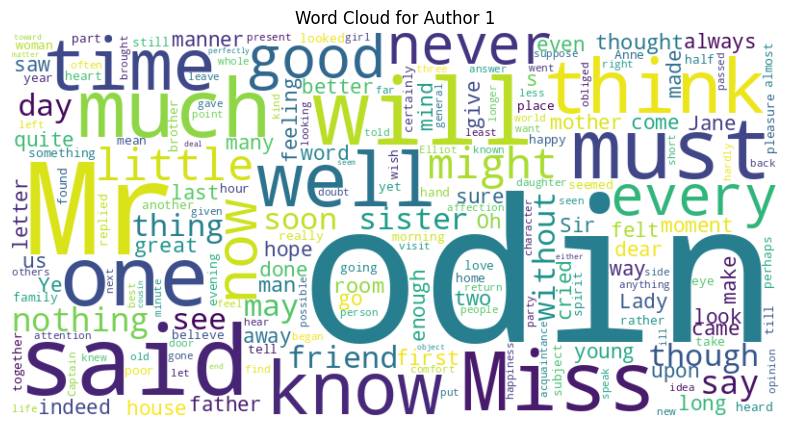

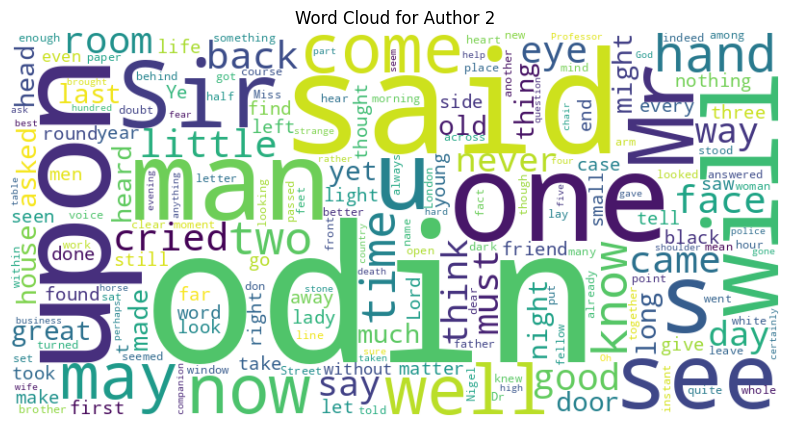

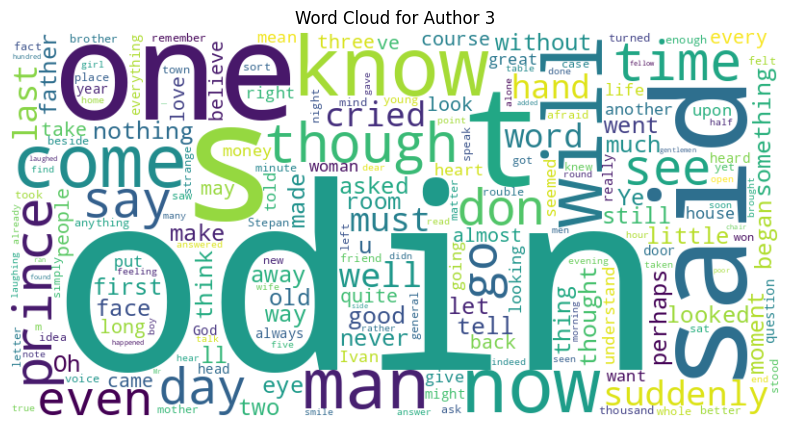

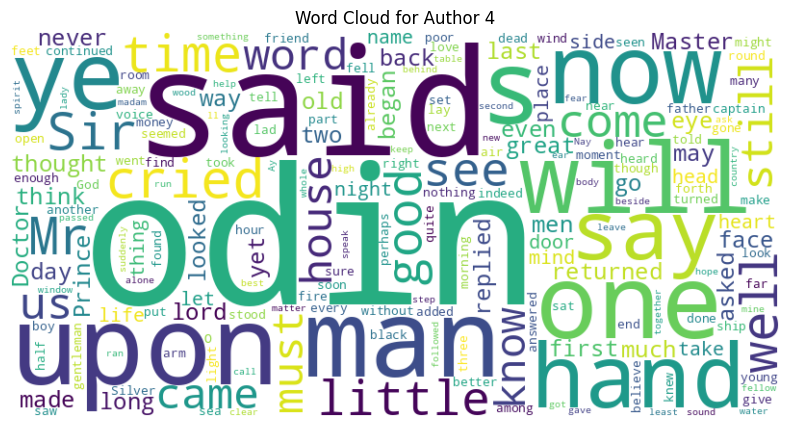

In [11]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Group DataFrame by author
grouped = train.groupby('author')

# Generate and plot word cloud for each author group
for author, group in grouped:
    # Concatenate text data for the current author group into a single string
    all_text = ' '.join(group['text'])

    # Generate word cloud for the current author group
    wordcloud = WordCloud(width=800, height=400, background_color='white', collocations=False, relative_scaling=0.5).generate(all_text)

    # Plot word cloud for the current author group
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for Author {author}')
    plt.axis('off')
    plt.show()

시각화 1 : 작가별 데이터 수

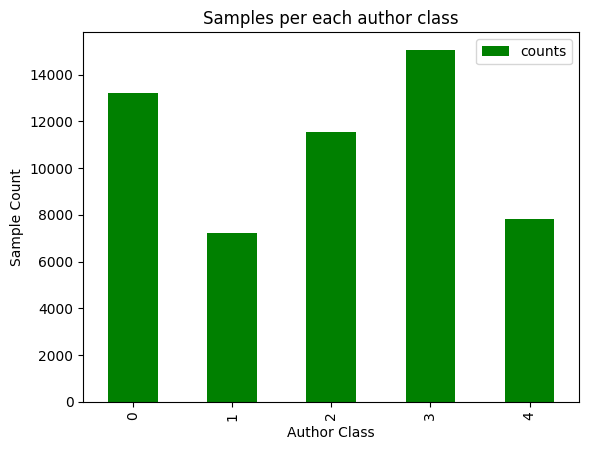

In [12]:
def plot_author_samples_bar(train_data):
    author_counts = train_data.groupby(train_data.author).size().reset_index(name="counts")
    author_counts.plot.bar(x='author', y='counts', title="Samples per each author class", color='green')
    plt.xlabel('Author Class')
    plt.ylabel('Sample Count')
    plt.show()

plot_author_samples_bar(train)

시각화2 : 데이터 길이 분포

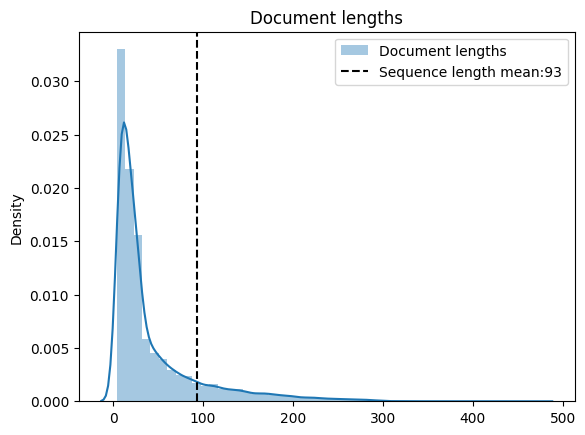

In [13]:
train['doc_len'] = train.text.apply(lambda words: len(words.split()))

def plot_doc_lengths(dataframe):
    max_seq_len = np.round(dataframe.doc_len.mean() + dataframe.doc_len.std()).astype(int)
    sns.distplot(tuple(dataframe.doc_len), hist=True, kde=True, label='Document lengths')
    plt.axvline(x=max_seq_len, color='k', linestyle='--', label=f'Sequence length mean:{max_seq_len}')
    plt.title('Document lengths')
    plt.legend()
    plt.show()

plot_doc_lengths(train)

시각화3 : 데이터 별 길이 분포

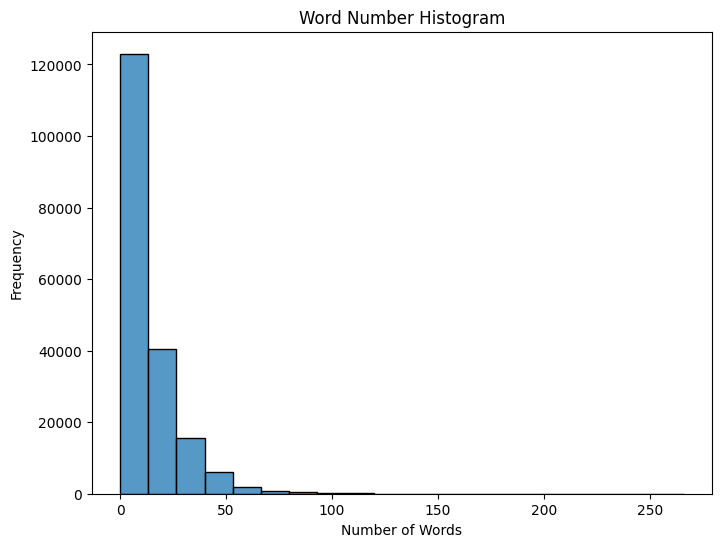

In [14]:
def plot_word_number_histogram(text_series):
    word_counts = [len(sentence.split()) for text in text_series for sentence in text.split('.')]
    plt.figure(figsize=(8, 6))  # Adjust figure size if needed
    sns.histplot(word_counts, bins=20, palette='viridis', edgecolor='black')
    plt.xlabel('Number of Words')
    plt.ylabel('Frequency')
    plt.title('Word Number Histogram')
    plt.show()

plot_word_number_histogram(train['text'])

시각화4 : 각 단어의 길이 분포

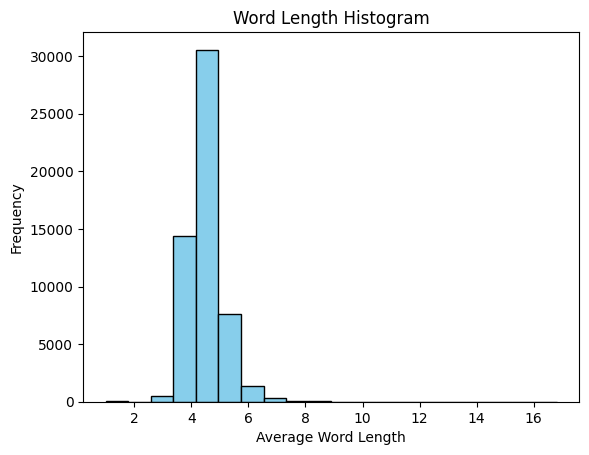

In [15]:
def plot_word_length_histogram(text_series):
    word_lengths = text_series.str.split().apply(lambda x: [len(word) for word in x]).map(np.mean)
    plt.hist(word_lengths, bins=20, color='skyblue', edgecolor='black')
    plt.xlabel('Average Word Length')
    plt.ylabel('Frequency')
    plt.title('Word Length Histogram')
    plt.show()

plot_word_length_histogram(train['text'])

시각화5 : test 데이터의 길이 분포

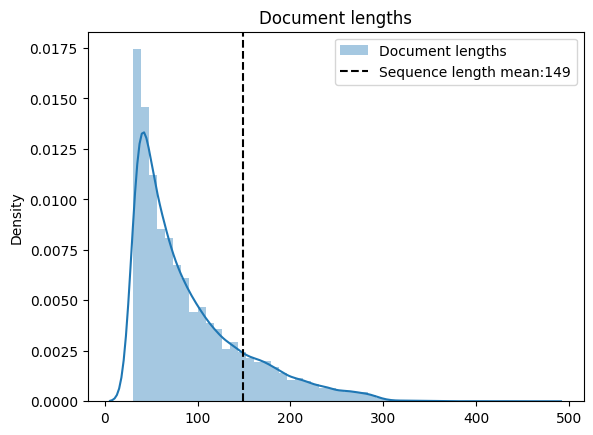

In [16]:
test['doc_len'] = test.text.apply(lambda words: len(words.split()))

plot_doc_lengths(test)

In [17]:
train.drop(['doc_len'], axis = 1, inplace = True)
test.drop(['doc_len'], axis = 1, inplace = True)

## 3. 전처리

In [18]:
# 텍스트에서 구두점을 제외한 단어 목록 반환
def get_words(text):
    words = nltk.tokenize.word_tokenize(text)
    return [word for word in words if not word in string.punctuation]

# 특정 토큰의 개수 셈
def count_tokens(text, tokens):
    words = nltk.tokenize.word_tokenize(text)
    return sum([w in tokens for w in words])

In [19]:
nltk.download('punkt')

train['num_words']=train['text'].apply(lambda x:len(get_words(x)))
train['num_;']=train['text'].apply(lambda x: count_tokens(x, ';'))
train['num_"']=train['text'].apply(lambda x: count_tokens(x, '”'))
train['num_.']=train['text'].apply(lambda x: count_tokens(x, '.'))
train['num_,']=train['text'].apply(lambda x: count_tokens(x, ','))
train['num_punctuations'] =train['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

test['num_words']=test['text'].apply(lambda x:len(get_words(x)))
test['num_;']=test['text'].apply(lambda x: count_tokens(x, ';'))
test['num_"']=test['text'].apply(lambda x: count_tokens(x, '"'))
test['num_.']=test['text'].apply(lambda x: count_tokens(x, '.'))
test['num_,']=test['text'].apply(lambda x: count_tokens(x, ','))
test['num_punctuations'] =test['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [20]:
nltk.download('stopwords')

# 불용어 제거해주는 함수
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stopwords:
            final_text.append(i.strip())
    return " ".join(final_text)

stopwords = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [21]:
#전처리 적용
train['text'] = train['text'].str.lower()
test['text'] = test['text'].str.lower()
# train['text'] = train['text'].apply(alpha_num).apply(remove_stopwords)
# test['text'] = test['text'].apply(alpha_num).apply(remove_stopwords)
train['text'] = train['text'].apply(remove_stopwords)
test['text'] = test['text'].apply(remove_stopwords)

In [ ]:
"""
# 특수문자 제거
def alpha_num(text):
    return re.sub(r'[^A-Za-z0-9 ]', '', text)
"""

## 4. 모델링

### 4-1. train/test data 설정

In [ ]:
# 숫자형 피처
cols_to_drop=['text','index']
X_train = train.drop(cols_to_drop+['author'], axis=1)
y_train = train['author']
X_test = test.drop(cols_to_drop, axis=1)

In [ ]:
# 텍스트 피처
text_train = train['text']
text_test = test['text']

### 4-2 토큰화

In [ ]:
# tokenizer에 fit
tokenizer = Tokenizer()
tokenizer.fit_on_texts(text_train)
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1

### 4-3. 데이터 sequence 변환 및 padding

In [ ]:
#파라미터 설정
vocab_size = 20000
embedding_dim = 16
max_length = 500
padding_type='post'

In [ ]:
# 데이터를 sequence로 변환해주고 padding 해줍니다.
train_sequences = tokenizer.texts_to_sequences(text_train)
train_padded = pad_sequences(train_sequences, padding=padding_type, maxlen=max_length)

test_sequences = tokenizer.texts_to_sequences(text_test)
test_padded = pad_sequences(test_sequences, padding=padding_type, maxlen=max_length)

In [ ]:
# 숫자형, 텍스트 피처 합치기
X_train_df = np.concatenate((X_train, train_padded), axis=1)
X_test_df = np.concatenate((X_test, test_padded), axis=1)

### 4-4. StratifiedKFold

In [ ]:
from sklearn.model_selection import StratifiedKFold

# Define the number of splits and epochs
n_splits = 5
num_epochs = 20

# Initialize stratified k-fold
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

### 4-5. 모델 생성 및 학습

In [ ]:
max_length2 = X_train_df.shape[1]
max_length2

106

In [ ]:
# EarlyStopping callback definition
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Placeholder for test set predictions
pred_list = []

for train_index, val_index in skf.split(train_padded, y_train):
    # NLP 모델 생성
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length2),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Conv1D(64, 5, padding="valid", activation="relu"),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.MaxPooling1D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(800, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(5, activation='softmax')
    ])

    # Compile the model
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    # Fit the model
    history = model.fit(X_train_fold, y_train_fold,
                        epochs=num_epochs, verbose=2,
                        validation_data=(X_val_fold, y_val_fold),
                        callbacks=[early_stopping])

    # Predict values for the test set and store them
    pred = model.predict(test_padded)
    pred_list.append(pred)


Epoch 1/20
1372/1372 - 96s - loss: 1.0077 - accuracy: 0.5957 - val_loss: 0.7180 - val_accuracy: 0.7310 - 96s/epoch - 70ms/step
Epoch 2/20
1372/1372 - 100s - loss: 0.5701 - accuracy: 0.7916 - val_loss: 0.6407 - val_accuracy: 0.7624 - 100s/epoch - 73ms/step
Epoch 3/20
1372/1372 - 98s - loss: 0.4171 - accuracy: 0.8505 - val_loss: 0.6526 - val_accuracy: 0.7664 - 98s/epoch - 71ms/step
Epoch 4/20
1372/1372 - 97s - loss: 0.3451 - accuracy: 0.8757 - val_loss: 0.6955 - val_accuracy: 0.7606 - 97s/epoch - 71ms/step
Epoch 5/20
1372/1372 - 94s - loss: 0.2932 - accuracy: 0.8946 - val_loss: 0.7215 - val_accuracy: 0.7675 - 94s/epoch - 69ms/step
614/614 [==============================] - 8s 13ms/step
Epoch 1/20
1372/1372 - 94s - loss: 1.0077 - accuracy: 0.5983 - val_loss: 0.7265 - val_accuracy: 0.7328 - 94s/epoch - 69ms/step
Epoch 2/20
1372/1372 - 91s - loss: 0.5716 - accuracy: 0.7936 - val_loss: 0.6371 - val_accuracy: 0.7655 - 91s/epoch - 66ms/step
Epoch 3/20
1372/1372 - 91s - loss: 0.4184 - accuracy:

### 4-6. 결과 확인

In [ ]:
pred_list

[array([[2.6124911e-02, 9.1298324e-01, 1.0752710e-02, 4.9209580e-02,
         9.2951348e-04],
        [1.6803342e-03, 9.5620430e-01, 1.5855579e-02, 3.4842347e-03,
         2.2775512e-02],
        [6.0264146e-01, 1.5172465e-01, 1.2224924e-01, 4.5507219e-02,
         7.7877529e-02],
        ...,
        [1.1790693e-02, 9.8557872e-01, 3.2587667e-04, 5.5875606e-04,
         1.7458082e-03],
        [2.4759674e-02, 9.6992004e-01, 5.8568484e-04, 1.3358345e-03,
         3.3987085e-03],
        [9.8016000e-01, 2.2648450e-03, 1.0294878e-02, 4.4495781e-04,
         6.8353927e-03]], dtype=float32),
 array([[1.2825023e-03, 4.1327515e-01, 4.3955860e-01, 1.4435260e-01,
         1.5311757e-03],
        [1.8354535e-02, 9.1019583e-01, 4.0533122e-02, 6.2316549e-03,
         2.4684811e-02],
        [9.4768077e-01, 4.7992345e-02, 1.8639686e-03, 2.3755175e-03,
         8.7444510e-05],
        ...,
        [5.6023459e-04, 9.9927831e-01, 8.2352990e-06, 1.3432186e-04,
         1.8980219e-05],
        [6.224131

In [ ]:
# Average the predictions for the test set
pred = np.mean(pred_list, axis=0)

In [ ]:
# submission
submission[['0','1','2','3','4']] = pred
submission.to_csv('/content/drive/MyDrive/ESAA/OB/data/project2/submission_최종.csv', index = False, encoding = 'utf-8')

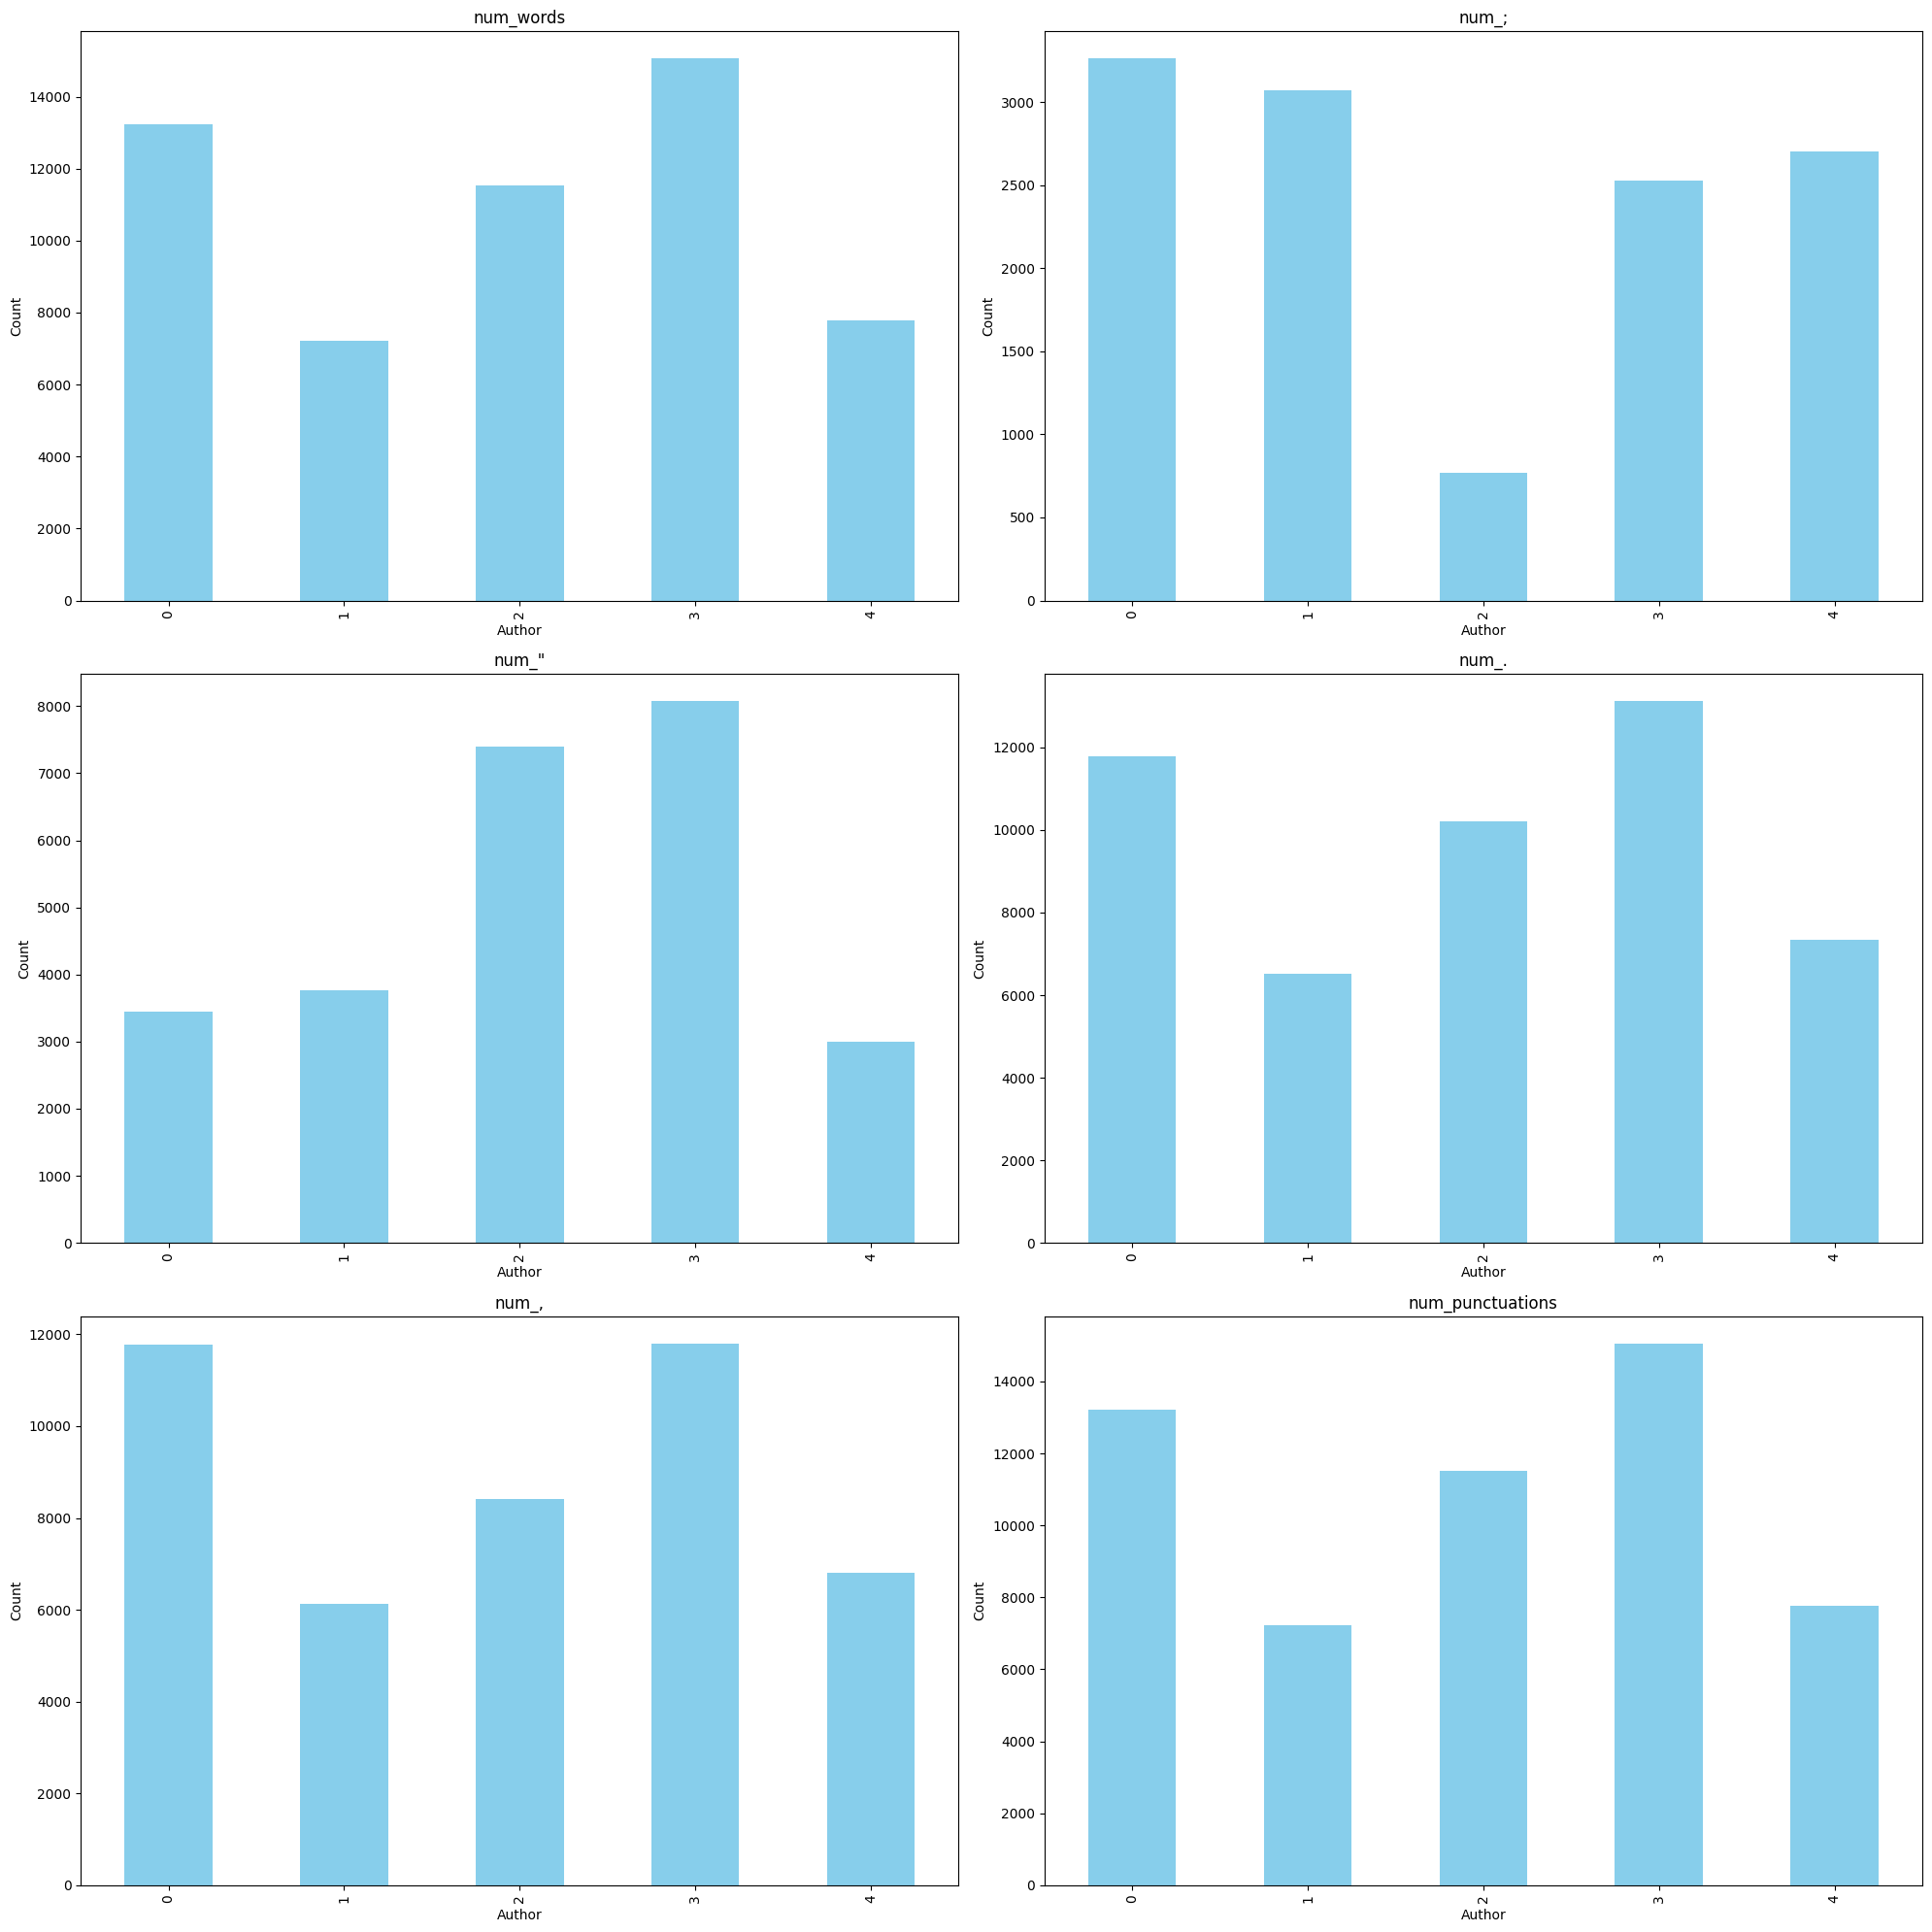

In [23]:
feature_list = ['num_words', 'num_;', 'num_"', 'num_.', 'num_,', 'num_punctuations']


fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(20, 20))
axes = axes.flatten()

for idx, feature in enumerate(feature_list):
    ax = axes[idx]
    df_feature = train[train[feature] != 0].groupby('author')[feature].count()
    df_feature.plot(kind='bar', ax=ax, color='skyblue')
    ax.set_title(feature)
    ax.set_xlabel('Author')
    ax.set_ylabel('Count')

plt.tight_layout()
plt.show()